# Objetivos

Queremos tomar el dataset de seaborn del titanic y evaluar diferentes modelos y sus metricas a la hora de predecir si un pasajero sobrevive o no.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# Limpieza

Vamos a hacer una limpieza simple

In [2]:

# La columna pclass y class parecen codificar para lo mismo, vamos a eliminar pclass y vamos a binarizar class
data = titanic.drop(["pclass"], axis=1)
one_hot = pd.get_dummies(data["class"], prefix = "class", drop_first = True)
data = data.join(one_hot)
data = data.drop(["class"], axis=1)
data.head()

# Binarizamos la columna sex
data["sex"] = data["sex"].map({"male":0,"female":1})

# Binarizamos la columna embarked
data = data.join(pd.get_dummies(data["embarked"], prefix = "embarked", drop_first = True))
data = data.drop(["embarked"], axis=1)

# Como las columnas sibsp y parch son parcialemente redundantes con alone, tiramos alone
# Como las columnas adult_male y who son redundantes con age y sex las tiramos
# Como la columna embark_town es redundante con enbarked la tiramos
data = data.drop(["alone","who","adult_male","embark_town"], axis=1)

# Binarizamos la columna alone
#data["alone"] = data["sex"].map({"no":0,"yes":1})

# Tiramos la columna alive porque no es un evento independiente de survived
# y la columna deck porque tiene muchos nans
data = data.drop(["alive","deck"], axis=1)

# Tiramos nans porque todavia hay algunos valores nans fuera de la columna deck
data = data.dropna()



In [3]:
data.head()


,survived,sex,age,sibsp,parch,fare,class_Second,class_Third,embarked_Q,embarked_S
0,0,0,22.0,1,0,7.2500,0,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0,0
2,1,1,26.0,0,0,7.9250,0,1,0,1
3,1,1,35.0,1,0,53.1000,0,0,0,1
4,0,0,35.0,0,0,8.0500,0,1,0,1


In [4]:
# Preparamos los datos de entrenamiento y vamos a probar con un modelo de regresion logistica
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(data.drop(["survived"], axis=1), data["survived"], test_size=0.2, random_state=42, stratify=data["survived"])

# Estandarizamos la matris de Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Preparamos el modelo
clf = LogisticRegression(C=1e10)
# Lo entrenamos
clf.fit(X_train, y_train)
# Buscamos la predicciones y su probabilidad
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

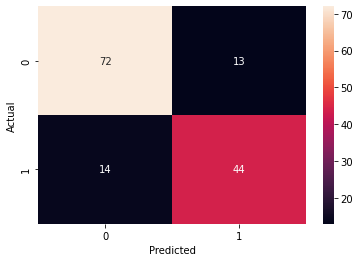

In [5]:
# Vamos a ver como dar diferentes metricas
from sklearn.metrics import confusion_matrix
import numpy as np

# Visualizamos la matriz de confusion
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, annot=True)


In [6]:
# Calculamos el accuracy  (Fraccion de aciertos)
from sklearn.metrics import accuracy_score

print('Accuracy=', accuracy_score(y_test, y_pred))

# Recordemos que hay que comparar con la hipotesis nula!
# Y que el dataset esta bastante desbalanceado.

print (y_test.value_counts(normalize=True))

Accuracy= 0.8111888111888111
0    0.594406
1    0.405594
Name: survived, dtype: float64


In [7]:
# Calculemos el recall (deteccion de positivos sobre los positivos reales)
from sklearn.metrics import recall_score
print(recall_score(y_test, y_pred))

# Notamos que es un poco peor el modelo.

0.7586206896551724


In [8]:
# Si queremos calcular la especifidad (que no haya negativos que pasen por positivos)
# Esta cuenta la hacemos a mano usando la matriz de confusion

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

specificity = TN / (TN + FP)

print(specificity)

0.8470588235294118


In [9]:
# Calculemos la precision (de los positivos, cuatos lo eran? No es lo mismo que el recall!)

from sklearn.metrics import precision_score
print(precision_score(y_test, y_pred))

0.7719298245614035


In [10]:
# Tambien podemos calcular la tasa de falsos positivos (FPR) que es la inversa de la especificidad

print(1-specificity)

0.15294117647058825


In [11]:
# O el F1 score que combina metricas

from sklearn.metrics import f1_score
print(f1_score(y_test,y_pred))

0.7652173913043477


c:\Users\Ionatan\anaconda3\envs\DH\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


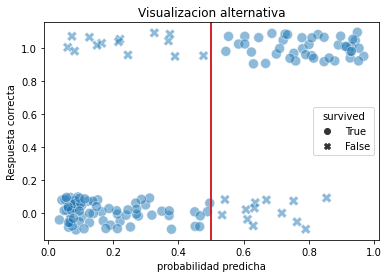

In [48]:
# Otra forma de verlo
import random

random.seed(0)

y_pred_proba # Logistic probability
y_test 
y_test_modificado = y_test + [random.random()/5-0.1 for _ in range(len(y_test))]
umbral = 0.5
umbral2 = 0.5
y_style_log = (y_pred_proba[:,1]>umbral) - y_test == 0

fig, ax = plt.subplots()

sns.scatterplot(y_pred_proba[:,1],y_test_modificado, alpha=0.5, style=y_style_log, style_order=[True, False], s=100, ax=ax)
plt.xlabel('probabilidad predicha')
plt.ylabel('Respuesta correcta')
plt.title('Visualizacion alternativa')
plt.axvline(x=umbral)
plt.axvline(x=umbral2, color='red')


# Curva ROC

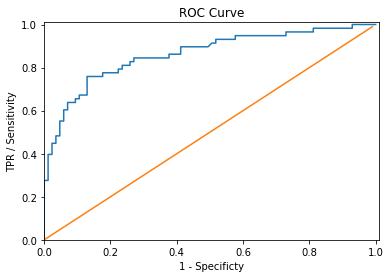

AUC= 0.8619675456389453


In [13]:
# Esto no mide tanto el ajuste en si, sino la capacidad de deteccion del modelo.


from sklearn.metrics import roc_curve 
import matplotlib.pyplot as plt

fpr_log,tpr_log,thr_log = roc_curve(y_test, y_pred_proba[:,1]) # Pedimos que haga las cuentas

df = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(df['fpr'],df['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

from sklearn.metrics import auc
print('AUC=', auc(fpr_log, tpr_log))

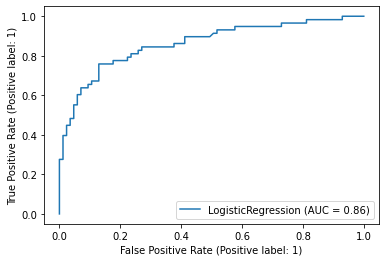

In [14]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(clf, X_test, y_test)


In [15]:
thr_log

array([1.96779755, 0.96779755, 0.86163719, 0.85394698, 0.79993303,
       0.78997251, 0.77836881, 0.7633425 , 0.75342053, 0.75277987,
       0.72072408, 0.7169203 , 0.68628833, 0.6693826 , 0.64585181,
       0.63263627, 0.62967257, 0.62918543, 0.62351954, 0.60677031,
       0.54512291, 0.48876555, 0.4767265 , 0.44967399, 0.38952774,
       0.37842355, 0.3737847 , 0.37120726, 0.36928833, 0.34901756,
       0.32607245, 0.25283357, 0.24521095, 0.22086603, 0.21621904,
       0.1694354 , 0.16463847, 0.15262655, 0.15049434, 0.12720931,
       0.12720774, 0.08575785, 0.08163436, 0.07470864, 0.07357003,
       0.06179424, 0.06044314, 0.03514154])

# Curvas ROC entre modelos

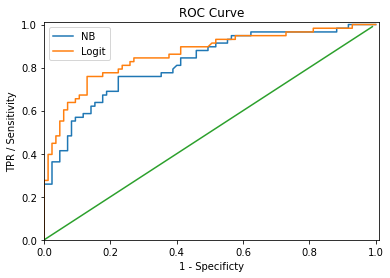

In [16]:
# Preparamos un modelo Naive Bayes

from sklearn.naive_bayes import GaussianNB

nbc = GaussianNB()

# Lo entrenamos
nbc.fit(X_train, y_train)
y_preds_nb = nbc.predict(X_test)
y_probs_nb = nbc.predict_proba(X_test)

# Graficamos ambos juntos

fpr_nb,tpr_nb,thr_nb = roc_curve(y_test, y_probs_nb[:,1])
fpr_log,tpr_log,thr_log = roc_curve(y_test, y_pred_proba[:,1])

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_nb,tpr_nb)
plt.plot(fpr_log,tpr_log)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend(['NB','Logit'])
plt.show() 

In [17]:
print('AUC_log=', auc(fpr_log, tpr_log))
print('AUC_nb=', auc(fpr_nb, tpr_nb))

AUC_log= 0.8619675456389453
AUC_nb= 0.8205882352941176


In [18]:
# Podemos comparar metricas:

print('Accuracy_logit=', accuracy_score(y_test, y_pred))
print('Accuracy_NB=', accuracy_score(y_test, y_preds_nb))

print('f1Score_logit=', f1_score(y_test, y_pred))
print('f1Score_NB=', f1_score(y_test, y_preds_nb))

Accuracy_logit= 0.8111888111888111
Accuracy_NB= 0.7482517482517482
f1Score_logit= 0.7652173913043477
f1Score_NB= 0.6896551724137931


c:\Users\Ionatan\anaconda3\envs\DH\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Ionatan\anaconda3\envs\DH\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


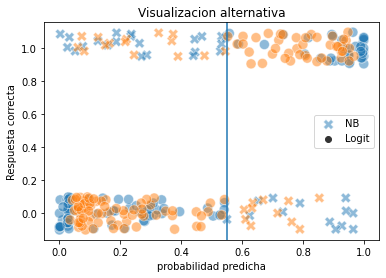

In [41]:
# Otra forma de verlo
import random

random.seed(0)

y_probs_nb # NaiveBayes probability
y_pred_proba # Logistic probability
y_test 
y_test_modificado = y_test + [random.random()/5-0.1 for _ in range(len(y_test))]
umbral = 0.55
#umbral2 = 0.4
y_style_nb = (y_probs_nb[:,1]>umbral) - y_test == 0
y_style_log = (y_pred_proba[:,1]>umbral) - y_test == 0

fig, ax = plt.subplots()


sns.scatterplot(y_probs_nb[:,1],y_test_modificado, alpha=0.5, style=y_style_nb, style_order=[True, False], s=100, ax=ax)
sns.scatterplot(y_pred_proba[:,1],y_test_modificado, alpha=0.5, style=y_style_log, style_order=[True, False], s=100, ax=ax)
ax.legend(['NB','Logit'])
plt.xlabel('probabilidad predicha')
plt.ylabel('Respuesta correcta')
plt.title('Visualizacion alternativa')
plt.axvline(x=umbral)
#plt.axvline(x=umbral2)



# Ejemplo de GridSearch y Knn


In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV


# Seteamos lo que queremos que se pruebe
knn = KNeighborsClassifier()
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)

# Seteamos la validacion cruzada
folds=StratifiedKFold(n_splits=10, random_state=19, shuffle=True)

# Seteamos el grid
grid = GridSearchCV(knn, param_grid, cv=folds)

# Entrenamos el modelo en todos los casos
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=19, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']})

In [21]:
# Observamos los resultados
display(grid.best_estimator_,grid.best_score_,grid.best_params_)

KNeighborsClassifier(n_neighbors=4)

0.8108590441621294

{'n_neighbors': 4, 'weights': 'uniform'}

In [22]:
# Aplicamos los resultados al test

y_pred_grid = grid.predict(X_test)

print('Accuracy_grid_knn=', accuracy_score(y_test, y_pred_grid))


Accuracy_grid_knn= 0.7622377622377622
